In [1]:
import numpy as np 
import pandas as pd 

import os
import librosa
from scipy.io import wavfile
import matplotlib.pyplot as plt
import librosa.display
import librosa.display as ipd

import seaborn as sns
from glob import glob
from IPython.display import Audio

In [89]:
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD

In [154]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Therms to work with audio in python

### Frecuency (Hz)
* Frecuency describes the difference of wavelenghts
* We interpretate frecuency has high and low pitches

### Intencity (db / Power)
* Intencity describes the amplitude (height) of the wave  

### Sample Rate
* Sample rate is specific to how the computer reads in the audio file. 
* Think of it as the "resolution" of the audio. 

# Reading audio files

In [2]:
sns.set_theme(style = "white", palette = None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
#color_cycle  = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [3]:
audio_files = glob(".\wav\*.wav")

In [4]:
Audio(audio_files[0])

In [5]:
y, sr = librosa.load(audio_files[0])

In [6]:
print(f"y: {y[:10]}")
print(f"shape {y.shape}")
print(f"sr {sr}")

y: [0.00073117 0.00245408 0.00336707 0.00215118 0.00033655 0.00025408
 0.00163246 0.00247751 0.0021811  0.0015379 ]
shape (41857,)
sr 22050


<AxesSubplot: title={'center': 'Raw Audio Example'}>

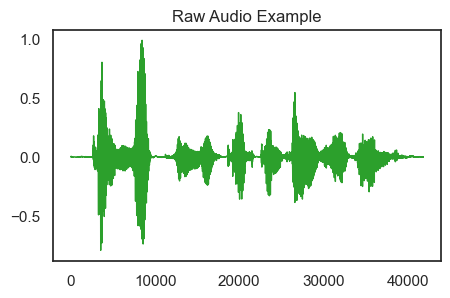

In [8]:
pd.Series(y).plot(figsize = (5, 3), lw = 1, title = "Raw Audio Example", color = color_pal[2])

<AxesSubplot: title={'center': 'Raw Audio Trimmed Example'}>

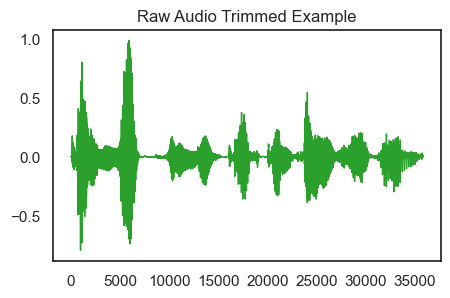

In [9]:
y_trimmed, _ = librosa.effects.trim(y, top_db=20)
pd.Series(y_trimmed).plot(figsize = (5, 3), lw = 1, title = "Raw Audio Trimmed Example", color = color_pal[2])

<AxesSubplot: title={'center': 'Raw Audio Zoomed Trimmed Example'}>

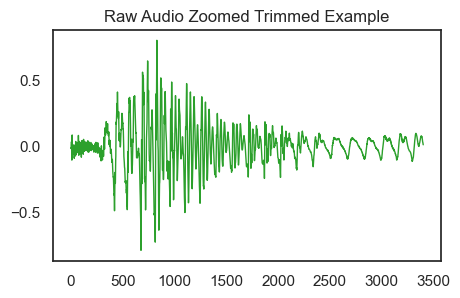

In [10]:
pd.Series(y_trimmed[300:3700]).plot(figsize = (5, 3), lw = 1, title = "Raw Audio Zoomed Trimmed Example", color = color_pal[2])

In [11]:
D = librosa.stft(y)
s_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
s_db.shape

(1025, 82)

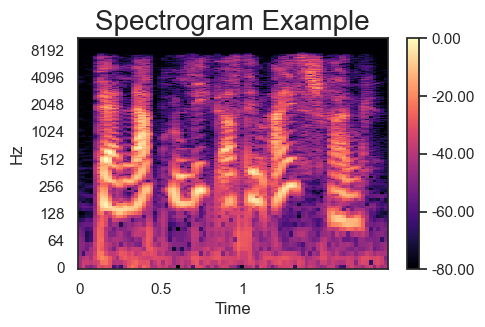

In [12]:
# Plot the transformed audio data

fig, ax = plt.subplots(figsize = (5, 3))
img = librosa.display.specshow(s_db, 
                              x_axis="time", 
                              y_axis="log", 
                              ax = ax)
ax.set_title("Spectrogram Example", fontsize = 20)
fig.colorbar(img, ax=ax, format =f"%0.2f")

In [13]:
S = librosa.feature.melspectrogram(y = y, 
                                  sr = sr, 
                                  n_mels = 128,)
S_db_mel = librosa.amplitude_to_db(S, ref=np.max)

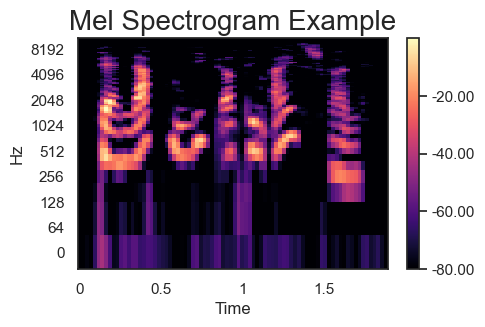

In [14]:
fig, ax = plt.subplots(figsize = (5, 3))
img = librosa.display.specshow(S_db_mel, 
                              x_axis="time", 
                              y_axis="log", 
                              ax = ax)
ax.set_title("Mel Spectrogram Example", fontsize = 20)
fig.colorbar(img, ax=ax, format =f"%0.2f")
plt.show()

# Create labels

In [52]:
label = []
for audio in audio_files:
    label.append(audio.split("\\")[2][5])

In [53]:
label = pd.DataFrame({"Etiqueta":label})

In [104]:
emotion = label.replace(["W", "L", "E", "A", "F", "T", "N"],["ANGER", "BOREDOM", "DISGUST", "FEAR", "HAPINESS", "SADNESS", "NEUTRAL"])

In [144]:
emotion = emotion.Etiqueta.values

'HAPINESS'

## GENERATE DATASET

In [68]:
Data = []
for audio in audio_files: 
    y, sr = librosa.load(audio)
    Data.append([y])
Data = np.array(Data)

In [83]:
import random

In [111]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = audio_files[0]
data, sample_rate = librosa.load(path)

In [112]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # Duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # Without AUGMENTATION
    res1 = extract_features(data)
    result = np.array(res1)
    
    # Data with NOISE
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # Data with NOISE is distinct from data with STRETCHING and PITCHING
    
    # Data with STRETCHING and PITCHING
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [126]:
# DataFiles = pd.DataFrame()    np.arange(0, len(audio_files), 1)

In [148]:
X, Y = [], []
index = 0

for file, label in zip(audio_files, emotion): 
    
    feature = get_features(file)
    if (index % 100 == 0):
        print("Import Data: RUNNING ... {} files".format(index))

    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(label)
    index+=1

C:\Users\dione\AppData\Local\Temp\ipykernel_8644\3114365475.py:7: FutureWarning: Pass rate=0.8 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.time_stretch(data, rate)
C:\Users\dione\AppData\Local\Temp\ipykernel_8644\3114365475.py:14: FutureWarning: Pass sr=22050, n_steps=0.7 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)


Import Data: RUNNING ... 0 files
Import Data: RUNNING ... 100 files
Import Data: RUNNING ... 200 files
Import Data: RUNNING ... 300 files
Import Data: RUNNING ... 400 files
Import Data: RUNNING ... 500 files


In [149]:
Features = pd.DataFrame(X)

In [150]:
Features['labels'] = Y
Features.to_csv('features.csv', index=False)

In [152]:
#Data Preparation and Normalization
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [155]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
print(X.shape)
print(Y.shape)

(1605, 162)
(1605, 7)


In [157]:
if X.shape[0] != Y.shape[0]:
  print("X and Y rows are mismatched, check dataset again")
x_train, x_test, y_train, y_test = train_test_split(X, Y,random_state=None, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1203, 162), (1203, 7), (402, 162), (402, 7))

In [158]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1203, 162, 1), (1203, 7), (402, 162, 1), (402, 7))

In [185]:
x_train.shape

(1203, 162, 1)

In [188]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM
input_x = tf.keras.layers.Input(shape = (x_train.shape[1],1))
conv_1 = tf.keras.layers.Conv1D(filters=16,kernel_size=3,padding="same",activation="relu")(input_x)
pool_1 = tf.keras.layers.MaxPooling1D(2)(conv_1)
conv_2 = tf.keras.layers.Conv1D(filters=32,kernel_size=3,padding="same",activation="relu")(pool_1)
pool_2  = tf.keras.layers.MaxPooling1D(2)(conv_2)

flatten = tf.keras.layers.Flatten()(pool_2)
dense = tf.keras.layers.Dense(512, activation="relu")(flatten)
fb = tf.keras.layers.Dropout(0.4)(dense)
fb = tf.keras.layers.Dense(512, activation="relu")(fb)
fb = tf.keras.layers.Dropout(0.4)(fb)

output = tf.keras.layers.Dense(8, activation="softmax")(fb)
model_branching_summed = tf.keras.models.Model(inputs=input_x, outputs=output)
model_branching_summed.summary()
model_branching_summed.compile(optimizer=SGD(learning_rate=0.01 , momentum=0.8), loss='categorical_crossentropy', metrics= ['accuracy'])

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 162, 1)]          0         
                                                                 
 conv1d_40 (Conv1D)          (None, 162, 16)           64        
                                                                 
 max_pooling1d_32 (MaxPoolin  (None, 81, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_41 (Conv1D)          (None, 81, 32)            1568      
                                                                 
 max_pooling1d_33 (MaxPoolin  (None, 40, 32)           0         
 g1D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 1280)              0  

In [176]:
from keras.utils.vis_utils import plot_model
plot_model(model_branching_summed, show_shapes=True, show_layer_names=True, to_file='model.png')
#Image(retina=True, filename='model.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [177]:
import keras.backend as K
import tensorflow as tf
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
METRICS = [
      tf.keras.metrics.Accuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

anger, \n
boredom
disgust
anxiety/fear
happiness
sadness
Neutral

In [192]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2,min_lr=0.0001)
#(min_lr=0.000001)


history=model_branching_summed.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/100


ValueError: in user code:

    File "C:\Users\dione\anaconda3\envs\Testing\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\dione\anaconda3\envs\Testing\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\dione\anaconda3\envs\Testing\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\dione\anaconda3\envs\Testing\lib\site-packages\keras\engine\training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\dione\anaconda3\envs\Testing\lib\site-packages\keras\engine\training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "C:\Users\dione\anaconda3\envs\Testing\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\dione\anaconda3\envs\Testing\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\dione\anaconda3\envs\Testing\lib\site-packages\keras\losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\dione\anaconda3\envs\Testing\lib\site-packages\keras\losses.py", line 2004, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\dione\anaconda3\envs\Testing\lib\site-packages\keras\backend.py", line 5532, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 7) and (None, 8) are incompatible
